In [23]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

2025-06-29 21:45:21.974492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 21:45:21.989674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751222722.008696   10430 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751222722.013557   10430 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751222722.036247   10430 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='rgb', # если использовать предобученную ч/б модель, то изменить этот параметр на 'grayscale'
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest', # Попробовать: bicubic (лучшая, но тяжёлая) lanczos3/5 (вроде норм)
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [5]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1751222726.565711   10430 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [6]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [7]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1067 изображений
Класс PNEUMONIA (1): 3141 изображений


2025-06-29 21:46:50.459741: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [9]:
#применим аугментацию
def augment_and_preprocess_train(image, label):
    image_augmented = data_augmentation_pipeline(image, training=True)

    image_float_0_1 = tf.image.convert_image_dtype(image_augmented, tf.float32)
    brightness_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    image_brightened = image_float_0_1 * brightness_factor
    image_brightened = tf.clip_by_value(image_brightened, 0.0, 1.0)

    image_for_resnet_preprocess = image_brightened * 255.0
    image_preprocessed = preprocess_input(image_for_resnet_preprocess) 

    return image_preprocessed, label

def preprocess_val_test(image, label):
    image = tf.cast(image, tf.float32) # Просто переводим в float32
    image_preprocessed = preprocess_input(image) # И применяем ту же предобработку ResNet
    return image_preprocessed, label


df_train_processed = df_train.map(augment_and_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [10]:
# создадим модель
tf.keras.backend.set_image_data_format('channels_last')
backbone = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=2e-4) 
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    epochs=10,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/10


I0000 00:00:1751222848.167764   10596 service.cc:152] XLA service 0x730d3401f240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751222848.167838   10596 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-29 21:47:29.220133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751222852.660913   10596 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751222873.062108   10596 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7982 - auc: 0.8414 - loss: 0.4370 - precision: 0.8494 - recall: 0.8833

132/132 ━━━━━━━━━━━━━━━━━━━━ 94s 380ms/step - accuracy: 0.7984 - auc: 0.8415 - loss: 0.4368 - precision: 0.8494 - recall: 0.8835 - val_accuracy: 0.7373 - val_auc: 0.4705 - val_loss: 0.6072 - val_precision: 0.7373 - val_recall: 0.9933 - learning_rate: 2.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8408 - auc: 0.8870 - loss: 0.3651 - precision: 0.8837 - recall: 0.9053

132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.8408 - auc: 0.8870 - loss: 0.3650 - precision: 0.8836 - recall: 0.9054 - val_accuracy: 0.7246 - val_auc: 0.4496 - val_loss: 0.6013 - val_precision: 0.7278 - val_recall: 0.9919 - learning_rate: 2.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - accuracy: 0.8628 - auc: 0.9023 - loss: 0.3391 - precision: 0.9068 - recall: 0.9057 - val_accuracy: 0.6182 - val_auc: 0.6895 - val_loss: 0.6044 - val_precision: 0.8399 - val_recall: 0.5966 - learning_rate: 2.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8693 - auc: 0.9109 - loss: 0.3264 - precision: 0.9089 - recall: 0.9156
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step - accuracy: 0.8693 - auc: 0.9109 - loss: 0.3264 - precision: 0.9089 - recall: 0.9156 - val_accuracy: 0.7197 - val_auc: 0.2756 - val_loss: 0.6784 - val_precision: 0.7321 - val_recall: 0.9761 - learning_rate

In [ ]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3594 - auc: 0.3709 - loss: 0.8659 - precision: 0.3062 - recall: 0.6667
Test Loss: 0.6602168679237366
Test Accuracy: 0.6442307829856873


In [27]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


2025-06-29 22:07:49.522701: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


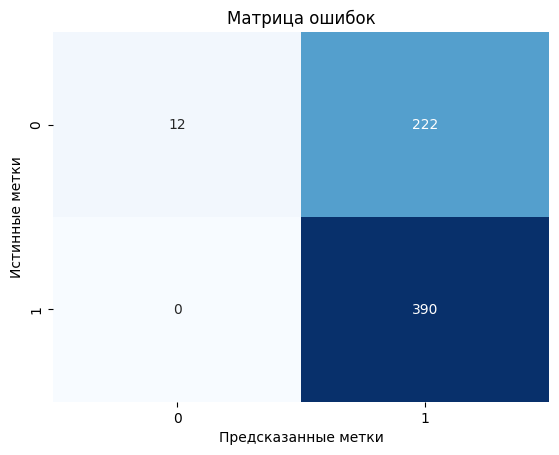

In [28]:

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()
